In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from keras import layers
from keras import regularizers, optimizers

import pathlib
import PIL
import PIL.Image

5286


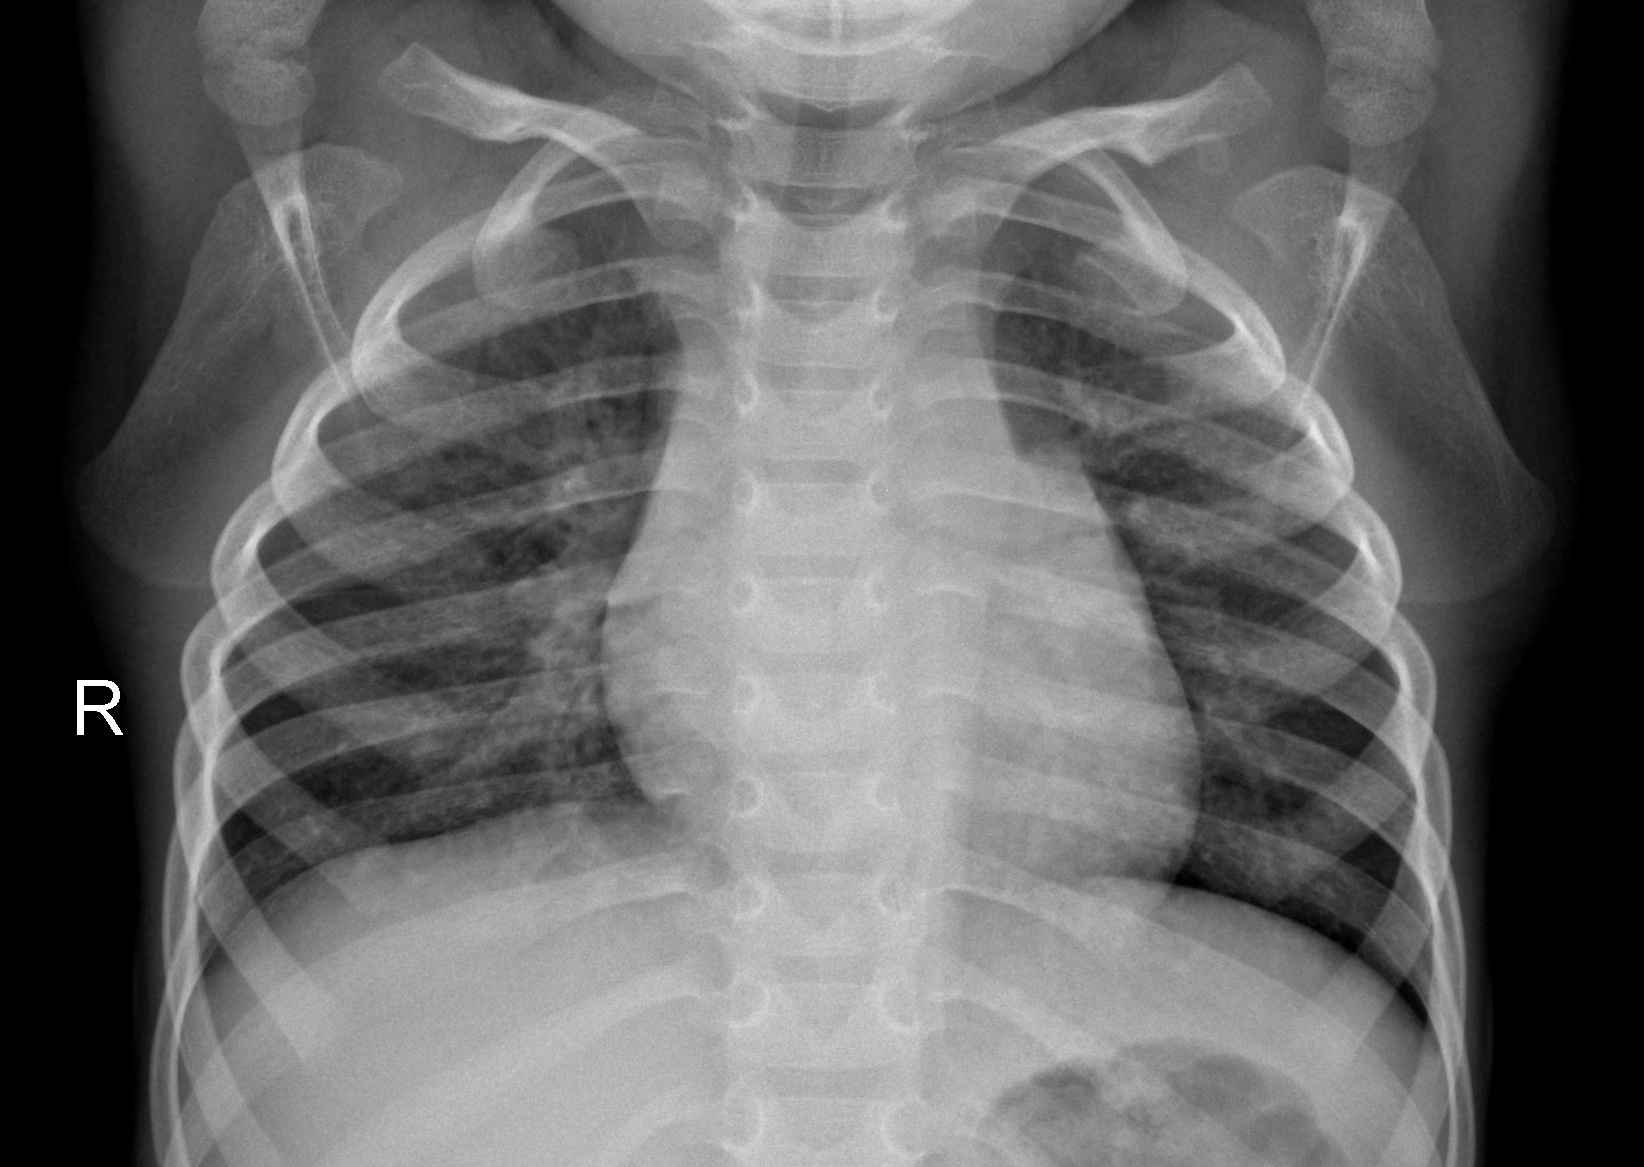

In [ ]:
input_dir = pathlib.Path("/content/drive/My Drive/input/4611_HW_5/")

train_metadata = pd.read_csv(pathlib.Path(input_dir, "assignment5_training_data_metadata.csv")).drop(columns=['id','cause'])
train_metadata = train_metadata.fillna("Normal")
train_metadata

test_metadata = pd.read_csv(pathlib.Path(input_dir, "assignment5_test_data_metadata.csv"))
test_metadata

data_dir = pathlib.Path(input_dir, "train")

train_images = list(data_dir.glob('*/*'))
image_count = len(train_images)
print(image_count)

PIL.Image.open(train_images[0])

In [ ]:
batch_size = 64
img_height = 200
img_width = 200

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
validation_split=0.2,subset='training',seed=42,image_size=(img_height,img_width), batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
validation_split=0.2,subset='validation',seed=42,image_size=(img_height,img_width), batch_size=batch_size)

class_names = train_ds.class_names

Found 5286 files belonging to 4 classes.
Using 4229 files for training.
Found 5286 files belonging to 4 classes.
Using 1057 files for validation.


In [ ]:
from keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling, RandomTranslation
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential()

model.add(RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)))
#model.add(RandomTranslation(0.3,0.3))
model.add(RandomRotation(0.3))
model.add(Rescaling(1./255))

model.add(Conv2D(10, (5, 5), padding='same',input_shape=(img_height,img_width,3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(AveragePooling2D())

model.add(Flatten())
model.add(Dense(60))
model.add(Activation('relu'))
model.add(Dense(42))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))

model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.build()
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip_8 (RandomFlip)   (None, 200, 200, 3)       0         
_________________________________________________________________
random_rotation_7 (RandomRot (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 200, 200, 10)      760       
_________________________________________________________________
activation_21 (Activation)   (None, 200, 200, 10)      0         
_________________________________________________________________
average_pooling2d_7 (Average (None, 100, 100, 10)      0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 100000)          

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=100)

Epoch 1/100
67/67 [==============================] - 41s 542ms/step - loss: 2.7248 - accuracy: 0.3742 - val_loss: 1.0404 - val_accuracy: 0.5043
Epoch 2/100
67/67 [==============================] - 2s 35ms/step - loss: 1.0798 - accuracy: 0.4591 - val_loss: 0.8773 - val_accuracy: 0.6206
Epoch 3/100
67/67 [==============================] - 2s 34ms/step - loss: 0.9409 - accuracy: 0.5690 - val_loss: 0.7900 - val_accuracy: 0.6594
Epoch 4/100
67/67 [==============================] - 2s 34ms/step - loss: 0.8647 - accuracy: 0.6208 - val_loss: 0.7312 - val_accuracy: 0.6783
Epoch 5/100
67/67 [==============================] - 2s 34ms/step - loss: 0.8407 - accuracy: 0.6232 - val_loss: 0.7345 - val_accuracy: 0.6651
Epoch 6/100
67/67 [==============================] - 2s 34ms/step - loss: 0.7879 - accuracy: 0.6464 - val_loss: 0.7024 - val_accuracy: 0.6859
Epoch 7/100
67/67 [==============================] - 2s 34ms/step - loss: 0.7732 - accuracy: 0.6566 - val_loss: 0.6952 - val_accuracy: 0.6812
Epoc

In [ ]:
np.mean(history.history['val_accuracy'])

0.7201229912042618

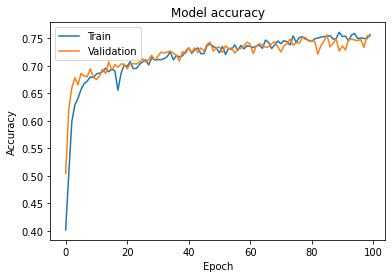

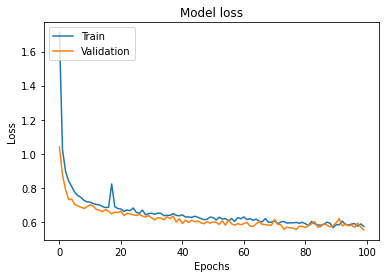

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir,shuffle=False,image_size=(img_height,img_width),batch_size=batch_size)

probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_ds)

test_paths = [pathlib.Path(x).name for x in test_ds.file_paths]
test_frame = pd.DataFrame({'image_name': test_paths, 'type': np.argmax(predictions, axis=1)+1})

submission_frame = test_frame.merge(train_metadata.reset_index().rename(columns={'index': 'id'})[['id', 'image_name']], on='image_name')
submission_frame = submission_frame[['id','image_name','type']]
submission_frame = submission_frame.sort_values('id').reset_index(drop=True)
submission_frame

Found 5286 files belonging to 4 classes.


,id,image_name,type
0,0,IM-0128-0001.jpeg,1
1,1,IM-0127-0001.jpeg,1
2,2,IM-0125-0001.jpeg,1
3,3,IM-0122-0001.jpeg,1
4,4,IM-0119-0001.jpeg,1
...,...,...,...
5281,5281,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,2
5282,5282,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,2
5283,5283,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,3
5284,5284,1-s2.0-S0140673620303706-fx1_lrg.jpg,2


In [ ]:
test_dir = pathlib.Path(input_dir,"test")
test_images = list(test_dir.glob("*/*"))
test_images[0]

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
label_mode=None,shuffle=False,image_size=(img_height,img_width),batch_size=64)

predictions = probability_model.predict(test_ds)

test_paths = [pathlib.Path(x).name for x in test_ds.file_paths]

test_frame = pd.DataFrame({'image_name': test_paths, 'type': np.argmax(predictions, axis=1) + 1})

Found 624 files belonging to 1 classes.


In [ ]:
test_frame.head(30)

,image_name,type
0,IM-0001-0001.jpeg,1
1,IM-0003-0001.jpeg,2
2,IM-0005-0001.jpeg,1
3,IM-0006-0001.jpeg,3
4,IM-0007-0001.jpeg,1
5,IM-0009-0001.jpeg,2
6,IM-0010-0001.jpeg,1
7,IM-0011-0001-0001.jpeg,1
8,IM-0011-0001-0002.jpeg,1
9,IM-0011-0001.jpeg,3


In [ ]:
from pandas.api.types import is_numeric_dtype


tmp = test_metadata
tmp['type'] = 0

pd.options.mode.chained_assignment = None

for i in range(0,len(tmp)):
  name = tmp['image_name'][i]

  if 'IM' in name:
    tmp['type'][i] = 1
  elif 'virus' in name:
    tmp['type'][i] = 2
  elif 'bacteria' in name:
    tmp['type'][i] = 3
  elif 'ards' in name:
    tmp['type'][i] = 4

tmp.head(30)

,id,image_name,type
0,5309,IM-0021-0001.jpeg,1
1,5310,IM-0019-0001.jpeg,1
2,5311,IM-0017-0001.jpeg,1
3,5312,IM-0016-0001.jpeg,1
4,5313,IM-0015-0001.jpeg,1
5,5314,IM-0013-0001.jpeg,1
6,5315,IM-0011-0001.jpeg,1
7,5316,IM-0011-0001-0002.jpeg,1
8,5317,IM-0011-0001-0001.jpeg,1
9,5318,IM-0010-0001.jpeg,1


In [ ]:
tmp2 = test_frame

tmp2['id'] = 0

tmp_names = list(tmp['image_name'].values)
tmp_ids = list(tmp['id'].values)

new_ids = []

for i in range(0,len(tmp2)):
  if tmp2['image_name'][i] in tmp_names:
    new_index = tmp_names.index(tmp2['image_name'][i])
    new_id = tmp['id'][new_index]
    new_ids.append(new_id)

count = 0

for i in range(0,len(new_ids)):
  if new_ids[i] not in tmp_ids:
    count += 1
    print("Did not find: ", new_ids[i])
count

tmp2['id'] = new_ids

In [ ]:
tmp2 = tmp2.sort_values(by='id')
tmp2 = tmp2.reset_index()
tmp2 = tmp2.drop(columns=['index'])

In [ ]:
acc = 0

for i in range(0,len(tmp2)):
  if tmp2['type'][i] == tmp['type'][i]:
    acc += 1
  #else:
    #print(tmp2['image_name'][i], "{", tmp2['type'][i] ,"} did not match: ", tmp['type'][i])

In [ ]:
perp = acc / len(tmp2)

print("Acc: ", perp)

Acc:  0.7884615384615384


In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
sample_sub = pd.read_csv('/content/drive/My Drive/input/4611_HW_5/assignment5_submission.csv')
sample_sub.head()

,id,type
0,5309,3
1,5310,2
2,5311,1
3,5312,3
4,5313,3


In [ ]:
tmp2 = tmp2.drop(columns=['image_name'])

tmp2 = tmp2.reindex(columns=['id','type'])

tmp2.head(10)

,id,type
0,5309,2
1,5310,1
2,5311,2
3,5312,1
4,5313,2
5,5314,1
6,5315,3
7,5316,1
8,5317,1
9,5318,1


In [ ]:
from datetime import datetime
from google.colab import files

from pytz import timezone
tz = timezone('US/Eastern')

submission = tmp2

sub_name = 'submission-' + datetime.now(tz).strftime("%I:%M:%S") + '.csv'

In [ ]:
pd.set_option('display.max_rows', len(submission)+1)
submission

,id,type
0,5309,2
1,5310,1
2,5311,2
3,5312,1
4,5313,2
5,5314,1
6,5315,3
7,5316,1
8,5317,1
9,5318,1


In [ ]:
submission['type'].value_counts()

3    285
2    173
1    166
Name: type, dtype: int64

In [ ]:
submission.to_csv(sub_name, index=False)

files.download(sub_name)
print('Created: ', sub_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Created:  submission-10:55:45.csv
